# Example MCMC analysis

This tutorial will go through running a likelihood analysis with CCL. It will compare "data" and "model" angular shear power spectra, to infer values for the $\Omega_c$ and $\sigma_8$ parameters.

In [1]:
import emcee # MCMC package https://emcee.readthedocs.io/en/stable/user/install/
import matplotlib.pyplot as plt 
import pyccl as ccl
import numpy as np
%matplotlib inline

# for nicer plots http://seaborn.pydata.org -- optional
# if you don't want to use it, you can comment this and the next line
import seaborn as sns; sns.set_style('darkgrid')
sns.set_context("talk")

## The "Data"

Let's create the "data" in the form of $C_\ell$ As a proof of point, we'll make the "data" using CCL (as a proof of concept $-$ normally you will want to input your real data here).

### First, we have to define a redshift distribution:

In [2]:
z = np.linspace(0., 3., 1024)
i_lim = 26. # Limiting i-band magnitude
z0 = 0.0417 * i_lim - 0.744

ell = np.arange(2, 2000)
delta_ell = ell[1] - ell[0]
Ngal = 46. * 100.31 * (i_lim - 25.) # Normalisation, galaxies/arcmin^2
pz = 1. / (2. * z0) * (z / z0)**2. * np.exp(-z / z0) # Redshift distribution, p(z)
dNdz = Ngal * pz # Number density distribution

Now let's set the cosmological parameters for our "data" and create it as an angular shear $C_\ell$

In [3]:
cosmo = ccl.Cosmology(Omega_c=0.27, 
                      Omega_b=0.045, 
                      h=0.67, 
                      n_s=0.96,  
                      sigma8=0.83, 
                      transfer_function='bbks')

tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz))
tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz))
data    = ccl.angular_cl(cosmo, tracer1, tracer2, ell) #C_ell

A simple plot to see how this looks:

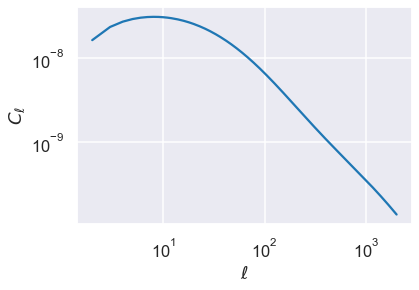

In [4]:
plt.plot(ell, data)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.show()

## Make a covariance matrix:
For the purpose of demonstration, we'll simply make a simplified diagonal covariance matrix without shape noise. Again you will want to input the actual covariance matrix here.

In [5]:
# C_ell^2/(Area of LSST survey*ell*delta ell)
cov = np.diag(data**2) * 2 * np.pi / ((4 * np.pi * 18000) * (np.pi / 180)**2 * ell * delta_ell) 
icov = np.linalg.inv(cov) #inverse of cov

## Run the MCMC:

Let's define our model that we want to test against our data. We'll use the same redshift distribution as above.

We will define `ln(probability)` (easier computationally that `probability`). Theta is the set of $\Omega_c$ and $\sigma_8$

For the likelihood analysis, we'll use MCMC to find the set of parameters that minimises $\chi^2 =(d - t)^T \cdot \Sigma^{-1} \cdot (d-t)$, with $\Sigma$: the covariance matrix $d$: data, and $t$: theory. The likelihood is then $L = e^{- \chi^2 / 2}$


In [6]:
def lnprob(theta):
    cosmo = ccl.Cosmology(
        Omega_c=theta[0], 
        Omega_b=0.045, 
        h=0.67, 
        n_s=0.96, 
        sigma8=theta[1], 
        transfer_function='bbks')
        
    tracer1 = ccl.WeakLensingTracer(cosmo, dndz = (z, dNdz))
    tracer2 = ccl.WeakLensingTracer(cosmo, dndz = (z, dNdz))
    model = ccl.angular_cl(cosmo, tracer1, tracer2, ell)
    diff = data - model
    return -np.dot(diff, np.dot(icov, diff)) / 2.0

We'll sample a 2-dimensional Gaussian

In [7]:
ndim = 2

Choose an initial set of positions for the walkers as a 2-d gaussian around some reasonable values:

In [8]:
nwalkers = 10
p0 = [np.array([0.27,0.83]) * np.ones(ndim) + np.array([0.05 * np.random.rand(),
      0.1 * np.random.rand()]) 
      for i in range(nwalkers)] 
p0 = np.array(p0)
p0 = p0 - len(p0) * [[0.025,0.05]]

Initialize the sampler with the chosen specs.

In [9]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

Run 50 steps as a burn-in

In [10]:
%time pos, prob, state = sampler.run_mcmc(p0, 50)

CPU times: user 6min 52s, sys: 5.03 s, total: 6min 57s
Wall time: 2min 2s


Reset the chain to remove the burn-in samples

In [11]:
sampler.reset()

Starting from the final position in the burn-in chain, sample for 100 steps

In [12]:
sampler.run_mcmc(pos, 100, rstate0 = state); 

Print out the mean acceptance fraction. In general, acceptance_fraction has an entry for each  walker so, in this case, it is a 10-dimensional vector.

In [13]:
print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.2f}")

Mean acceptance fraction: 0.70


Get the samples from the results to plot them later:

In [14]:
samples = sampler.chain[:, :, :].reshape((-1, ndim))

Results as mean and $95\%$ Confidence interval of $\Omega_c$ and $\sigma_8$:

In [15]:
mapout=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [2.5, 50, 97.5],
                                                axis=0)))

Results as a contour plot of the two parameters $-$ $\Omega_c$ and $\sigma_8$:

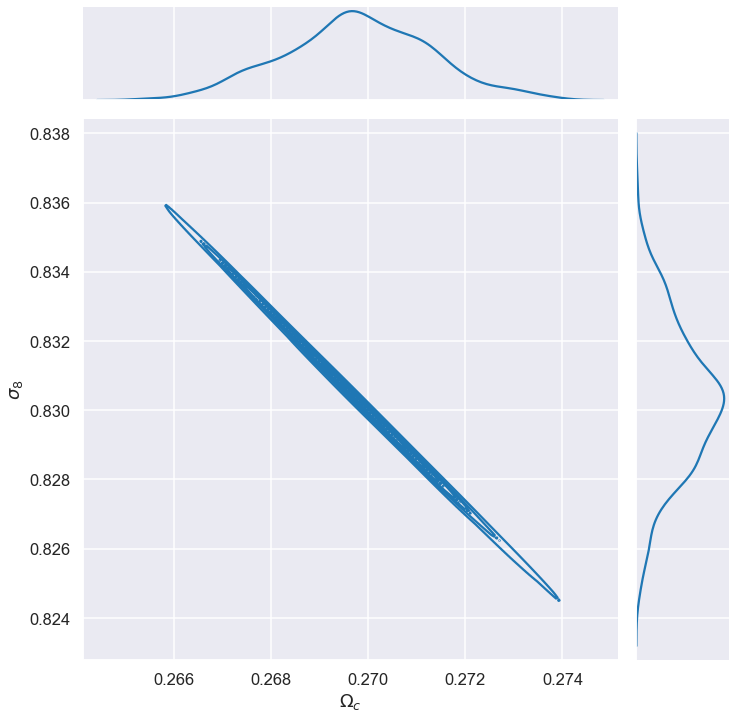

In [16]:
sns.jointplot(
    data=mapout,
    x=samples[:,0],
    y=samples[:,1],
    kind='kde',
    height=10).set_axis_labels(r"$\Omega_c$", r"$\sigma_8$")